In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 

from kaggle_environments import evaluate, make
from kaggle_environments.envs.halite.helpers import *

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.trajectories import time_step as ts
from tf_agents.networks import categorical_q_network
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.policies.policy_saver import PolicySaver
from tf_agents.specs import BoundedArraySpec

from random import randint

Loading environment football failed: No module named 'gfootball'


# Hyperparameters

In [2]:
num_iterations = 20000 # @param {type:"integer"}

num_atoms = 51 # @param {type:"integer"} number of atoms for Categorical Q-Network
min_q_value = -1000
max_q_value = 1000 
epsilon_greedy = 0.1 # @param {type:"float"}

initial_collect_steps = 400  # @param {type:"integer"} 
collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Environment

In [3]:
def time_step_ok(time_step_nok):
    tensors = []
    for array in time_step_nok:
        new_array = np.expand_dims(array, axis=0)
        tensor = tf.constant(new_array)
        tensors.append(tensor)
        
    # step_type
    # reward
    # discount
    # observation
    
    return ts.TimeStep(tensors[0], tensors[1], tensors[2], tensors[3])

In [4]:
# def opponent_agent(obs, config, policy):
#     board = Board(obs, config)
#     me = board.opponents[0]
    
#     policy_obs = train_py_env.get_observation(board, position=me.ships[0].position, player_id=me.id)
    
#     if obs.step == 0:
#         time_step = ts.restart(policy_obs)
#     elif obs.step >= config.episodeSteps-1:
#         time_step = ts.termination(policy_obs, reward=0)
#     else:
#         time_step = ts.transition(policy_obs, reward=0)
    
#     time_step = time_step_ok(time_step)
    
#     action_int = int(policy.action(time_step).action)
#     action = train_py_env._action_def[action_int]
    
#     return action

In [5]:
class HaliteWrapper(py_environment.PyEnvironment):
    def __init__(self):
        
        # Create environment and board 
        self._board_size = 7
        self._agent_count = 2
        self._max_turns = 20
        self._starting_halite = 2500
        self.env = make("halite", configuration={'episodeSteps':self._max_turns, 'size':self._board_size, 
                                                 'startingHalite':self._starting_halite})
        self.state = self.env.reset(num_agents=self._agent_count)
        
        self.obs = self.state[0].observation
        self.config = self.env.configuration
        self.max_cell_halite = self.config.maxCellHalite
        self.board = Board(self.obs, self.config)
        
        # Define observation and action specs 
        self.observation_shape = self.get_observation(self.board).shape
        self._observation_spec = BoundedArraySpec(
            shape=self.observation_shape, 
            dtype=np.int64, maximum=None, minimum=None)
        
        self._action_def = {0: None,
                            1: ShipAction.NORTH,
                            2: ShipAction.EAST,
                            3: ShipAction.SOUTH,
                            4: ShipAction.WEST,
#                             5: ShipAction.CONVERT
                           }
        self._action_spec = BoundedArraySpec(shape=(), dtype=np.int32, maximum=len(self._action_def)-1, minimum=0)
        
        # Define opponent behaviour 
        self.opponent_behaviour = 'static'
        self.opponent_policy = None
        
        # Define counters 
        self.turn_counter = 1 # turn that will be solved on next step, not last solved turn
        self.previous_cargo_halite = 0
        self.opponent_previous_cargo_halite = 0
        self.game_over = False
        
    def get_observation(self, board, position=(0,0), player_id=0):
        size = board.configuration.size

        halite = np.array(board.observation['halite']).reshape(size, size)
        halite = np.tile(halite, (3,3))

        # convert Halite SDK position format to np matrix 
        row = size - 1 - position[1] + size
        col = position[0] + size
        radius = 4
        halite_radius = halite[row-radius+1:row+radius, col-radius+1:col+radius]
        halite_radius = np.expand_dims(halite_radius, axis=-1)

        # ship radar 
        if board[position].ship:
            ref_halite = board[position].ship.halite
            ref_ship_id = board[position].ship.id
        else:
            ref_halite = 0
            ref_ship_id = None 

        ships = np.zeros((size, size))
        for ship in board.ships.values():
            if ship.player_id == player_id: # ally
                if ship.id == ref_ship_id:
                    value = 0
                else:
                    value = -1
            elif ship.halite > ref_halite: # opponent with more halite
                value = 1
            else: # opponent with equal or less halite 
                value = -2
            ships[size-1-ship.position[1], ship.position[0]] = value

        ships = np.tile(ships, (3,3))
        ships_radius = ships[row-radius+1:row+radius, col-radius+1:col+radius]
        ships_radius = np.expand_dims(ships_radius, axis=-1)

        # # On pourra ajouter ships, ship_cargo et base 
        observation = np.concatenate([halite_radius, ships_radius], axis=-1)
        observation = np.array(observation, dtype='int64')
        return observation
        
    def observation_spec(self):
        return self._observation_spec
    
    def action_spec(self):
        return self._action_spec
    
    def _reset(self):
        # reset environment and board
        self.env = make("halite", configuration={'episodeSteps':self._max_turns, 'size':self._board_size, 
                                                 'startingHalite':self._starting_halite})
        self.state = self.env.reset(num_agents=self._agent_count)
        
        self.obs = self.state[0].observation
        self.config = self.env.configuration
        self.max_cell_halite = self.config.maxCellHalite
        self.board = Board(self.obs, self.config)
        
        # reset ALL counters
        self.turn_counter = 1
        self.previous_cargo_halite = 0
        self.opponent_previous_cargo_halite = 0
        self.game_over = False
        
        observation = self.get_observation(self.board, position=self.board.players[0].ships[0].position, player_id=0)
        
        return_object = ts.restart(observation)
        
        return return_object
    
    def _step(self, action):
        
        if self.game_over:
            return self._reset()
        
        # Agent action
        action = int(action)
        self.board.ships['0-1'].next_action = self._action_def[action]
        
        # Opponent action
#         self.board.ships['0-2'].next_action = opponent_agent(self.obs, self.config, self.opponent_policy)
#         self.board.ships['0-2'].next_action = self._action_def[randint(1,4)]
#         self.board.ships['0-2'].next_action = None
        self.board.ships['0-2'].next_action = self.opponent_agent()
        
        self.board = self.board.next()
        
        # Calculate reward
        if len(self.board.players[0].ships) == 0: # ship destroyed
            reward = -10000
        elif len(self.board.players[1].ships) == 0: # enemy ship destroyed
            reward = 10000
        else:
            reward = (self.board.ships['0-1'].halite - self.previous_cargo_halite 
                      - (self.board.ships['0-2'].halite - self.opponent_previous_cargo_halite))
        
        # Update all counters 
        self.turn_counter += 1
        if len(self.board.players[0].ships) > 0:
            self.previous_cargo_halite = self.board.ships['0-1'].halite
        else:
            self.previous_cargo_halite = 0
        
        if len(self.board.players[1].ships) > 0:
            self.opponent_previous_cargo_halite = self.board.ships['0-2'].halite
        else:
            self.opponent_previous_cargo_halite = 0
            
        if self.turn_counter >= self._max_turns:
            self.game_over = True
        elif len(self.board.players[0].ships) == 0 or len(self.board.players[1].ships) == 0:
            self.game_over = True
            
        if len(self.board.players[0].ships) > 0:
            observation = self.get_observation(self.board, position=self.board.players[0].ships[0].position, player_id=0)
        else:
            observation = self.get_observation(self.board, position=(0,0), player_id=0)
        
        # Return 
        if self.game_over:
            return_object = ts.termination(observation, reward)
            return return_object
        else:
            return_object = ts.transition(observation, reward, discount=1.0)
            return return_object
        
    def set_opponent_behaviour(self, behaviour, policy_file=None):
        """
        Set opponent behaviour internal variables. 
        If behaviour is load_policy then policy_file must be specified. 
        """
        self.opponent_behaviour = behaviour
        if policy_file:
            self.opponent_policy = tf.saved_model.load(policy_file)
            
    def opponent_agent(self):
        """
        Return opponent action based on opponent behaviour. 
        """
        
        if self.opponent_behaviour == 'static':
            action = None
            
        elif self.opponent_behaviour == 'random_moving':
            action = self._action_def[randint(1,4)]
            
        elif self.opponent_behaviour == 'random_collecting':
            action = self._action_def[randint(0,4)]
            
        elif self.opponent_behaviour == 'load_policy':
            me = self.board.opponents[0]
            observation = self.get_observation(self.board, position=me.ships[0].position, player_id=me.id)
            
            if self.obs.step == 0:
                time_step = ts.restart(observation)
            elif self.obs.step >= self.config.episodeSteps-1:
                time_step = ts.termination(observation, reward=0)
            else:
                time_step = ts.transition(observation, reward=0)
            
            time_step = time_step_ok(time_step)
            
            action_int = int(self.opponent_policy.action(time_step).action)
            action = self._action_def[action_int]

        return action

In [6]:
train_py_env = HaliteWrapper()
eval_py_env = HaliteWrapper()

In [7]:
# train_py_env.set_opponent_behaviour(behaviour='random_collecting', policy_file=None)
# eval_py_env.set_opponent_behaviour(behaviour='random_collecting', policy_file=None)

train_py_env.set_opponent_behaviour(behaviour='load_policy', policy_file='my_policy')
eval_py_env.set_opponent_behaviour(behaviour='load_policy', policy_file='my_policy')

In [9]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [10]:
preprocessing_layers = tf.keras.models.Sequential()
preprocessing_layers.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), input_shape=train_py_env.observation_shape, 
                                                padding='same', activation='relu'))
preprocessing_layers.add(tf.keras.layers.Flatten())

fc_layer_params = (128,128)

q_net = categorical_q_network.CategoricalQNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    preprocessing_layers=preprocessing_layers,
    num_atoms=num_atoms, 
    fc_layer_params=fc_layer_params)

In [11]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=q_net,
    optimizer=optimizer,
    min_q_value=min_q_value, 
    max_q_value=max_q_value,
    epsilon_greedy=epsilon_greedy,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [12]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [13]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [14]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [20]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-372.6

In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 7, 7, 2), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.int64, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [22]:
iterator = iter(dataset)

print(iterator)

In [23]:
#@test {"skip": true}
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 2.0099306106567383
step = 400: loss = 3.0493149757385254
step = 600: loss = 3.4652674198150635
step = 800: loss = 3.543189525604248
step = 1000: loss = 3.593977928161621
step = 1000: Average Return = -1227.5
step = 1200: loss = 3.6401185989379883
step = 1400: loss = 3.4741404056549072
step = 1600: loss = 3.34820556640625
step = 1800: loss = 3.3275132179260254
step = 2000: loss = 3.398744583129883
step = 2000: Average Return = -52.400001525878906
step = 2200: loss = 3.354667901992798
step = 2400: loss = 3.241295099258423
step = 2600: loss = 3.6538095474243164
step = 2800: loss = 3.4876492023468018
step = 3000: loss = 3.443692207336426
step = 3000: Average Return = -1178.300048828125
step = 3200: loss = 3.431696891784668
step = 3400: loss = 3.3996219635009766
step = 3600: loss = 3.4876036643981934
step = 3800: loss = 3.39984130859375
step = 4000: loss = 3.1462562084198
step = 4000: Average Return = -1933.800048828125
step = 4200: loss = 3.171229839324951
step = 4400: l

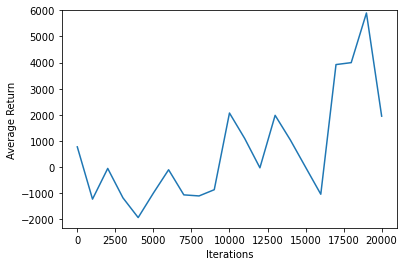

In [29]:
#@test {"skip": true}

import matplotlib.pyplot as plt

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=6000)

plt.savefig('return_per_iteration.png', bbox_inches='tight')

In [30]:
# Pour visualiser le comportement de l'agent par print de boards successifs
# time_step = eval_env.reset()
# print(eval_py_env.board)

# while not time_step.is_last():
#     action_step = eval_policy.action(time_step)
#     print(eval_py_env._action_def[int(action_step.action)])
#     time_step = eval_env.step(action_step.action)
#     print(eval_py_env.board)

In [31]:
compute_avg_return(eval_env, agent.policy, num_eval_episodes)

6941.5

In [32]:
def my_rl_agent(obs, config):
    board = Board(obs, config)
    me = board.current_player
    
    observation = train_py_env.get_observation(board, position=me.ships[0].position, player_id=me.id)
    
    if obs.step == 0:
        time_step = ts.restart(observation)
    elif obs.step >= config.episodeSteps-1:
        time_step = ts.termination(observation, reward=0)
    else:
        time_step = ts.transition(observation, reward=0)
    
    time_step = time_step_ok(time_step)
    
    action_int = int(eval_policy.action(time_step).action)
    action = train_py_env._action_def[action_int]
    
    for ship in me.ships:
        ship.next_action = action

    return me.next_actions

In [33]:
def random_ship_agent(obs, config):
    board = Board(obs, config)
    me = board.current_player
    
    for ship in me.ships:
        ship.next_action = train_py_env._action_def[randint(0,4)]
    
    return me.next_actions

def static_ship_agent(obs, config):
    board = Board(obs, config)
    me = board.current_player
    
    return me.next_actions

def random_moving_ship_agent(obs, config):
    board = Board(obs, config)
    me = board.current_player
    
    for ship in me.ships:
        ship.next_action = train_py_env._action_def[randint(1,4)]
    
    return me.next_actions

In [53]:
train_py_env._reset()
env = train_py_env.env
env.run([my_loaded_rl_agent, random_moving_ship_agent])
env.render(mode='ipython', width=400, height=300)

In [45]:
saver = PolicySaver(agent.policy, batch_size=None)

In [46]:
saver.save('my_policy')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: my_policy\assets


INFO:tensorflow:Assets written to: my_policy\assets


In [36]:
load_policy = tf.saved_model.load('my_policy')

In [37]:
def my_loaded_rl_agent(obs, config):
    board = Board(obs, config)
    me = board.current_player
    
    policy_obs = train_py_env.get_observation(board, position=me.ships[0].position, player_id=me.id)
    
    if obs.step == 0:
        time_step = ts.restart(policy_obs)
    elif obs.step >= config.episodeSteps-1:
        time_step = ts.termination(policy_obs, reward=0)
    else:
        time_step = ts.transition(policy_obs, reward=0)
    
    time_step = time_step_ok(time_step)
    
    action_int = int(load_policy.action(time_step).action)
    action = train_py_env._action_def[action_int]
    
    for ship in me.ships:
        ship.next_action = action

    return me.next_actions

In [59]:
train_py_env._reset()
env = train_py_env.env
env.run([my_rl_agent, my_loaded_rl_agent])
env.render(mode='ipython', width=400, height=300)